In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
%matplotlib inline

## Calibrate Camera

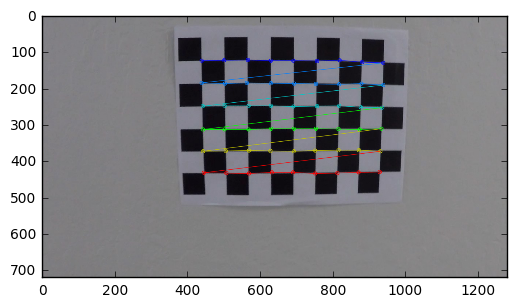

In [210]:
import glob

objpoints = [] # Objects in real world space
imgpoints = [] # Objects in 2-D space

nx, ny = 9, 6

objp = np.zeros((nx * ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

imgs = glob.glob('./camera_cal/*.jpg')

for fname in imgs:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)

In [212]:
print(img.shape)
print(gray.shape[::-1])

(720, 1280, 3)
(1280, 720)


In [231]:
img.shape[1::-1]

(1280, 720)


## Distort correction

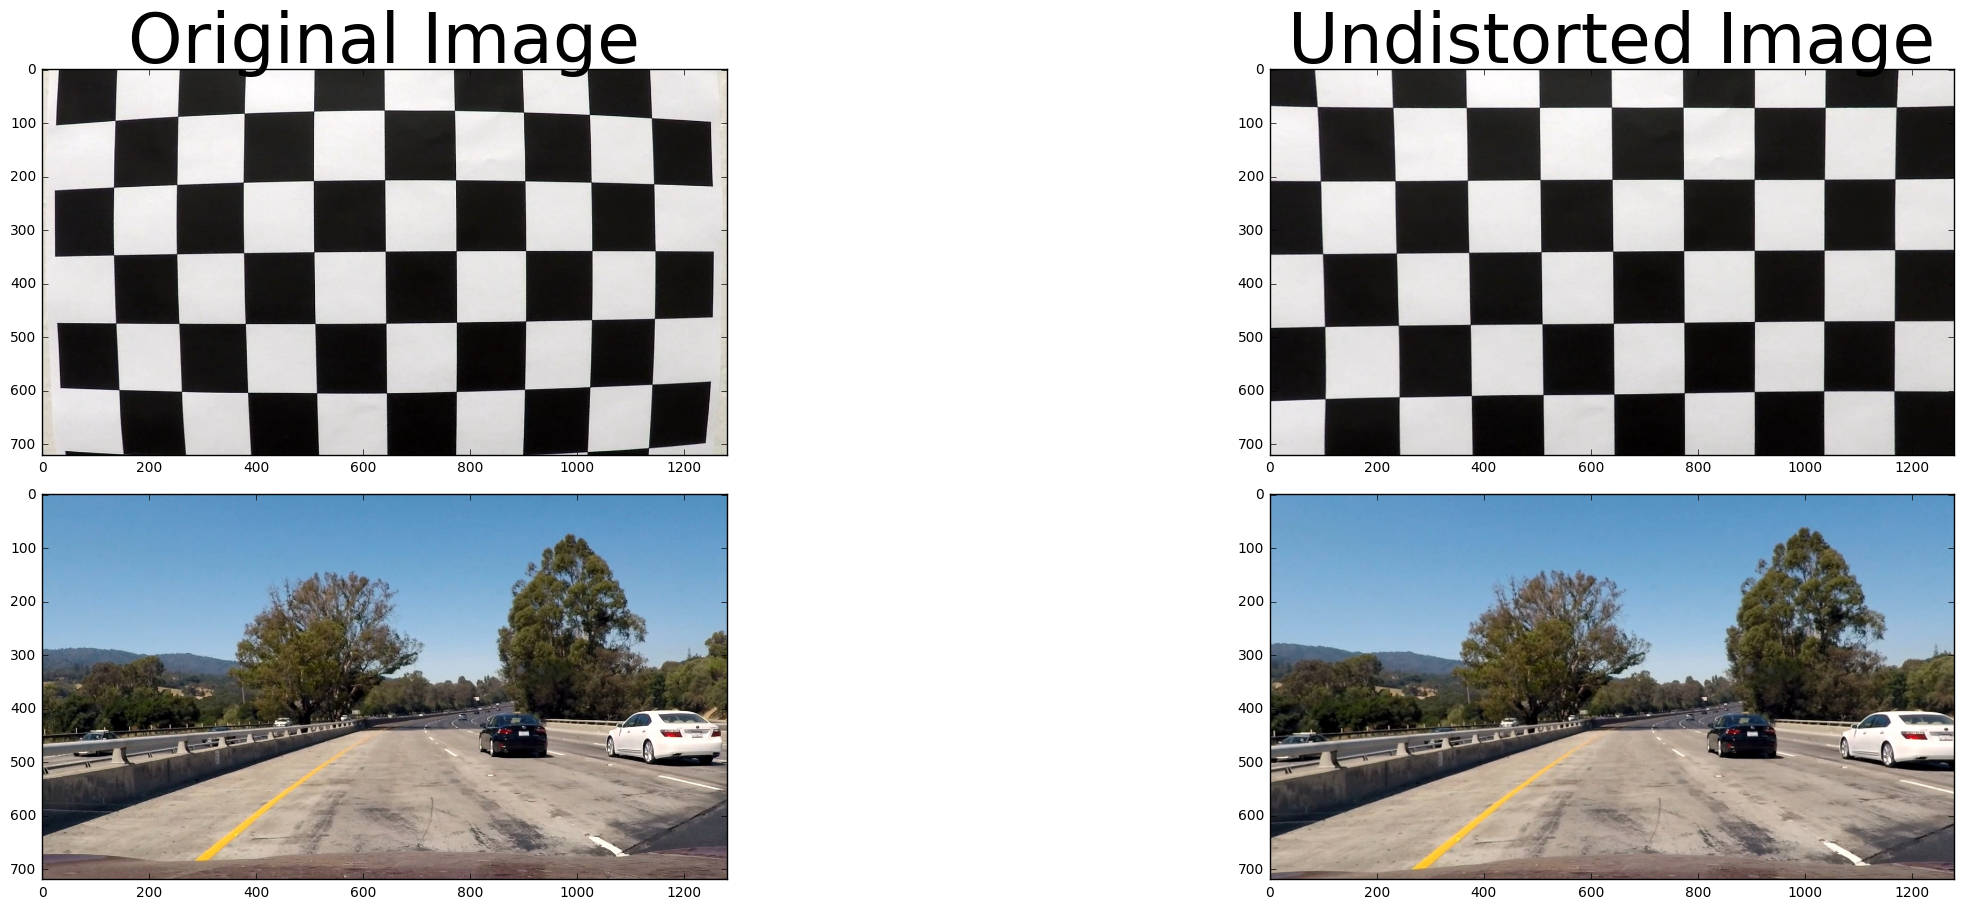

In [232]:
def undistort(img, imgpts, objpts):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, img.shape[1::-1], None, None)
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted
    
    
img = mpimg.imread('./camera_cal/calibration1.jpg')
undistorted = undistort(img, imgpoints, objpoints)

f, axarr = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()
axarr[0, 0].imshow(img)
axarr[0, 0].set_title('Original Image', fontsize=50)
axarr[0, 1].imshow(undistorted)
axarr[0, 1].set_title('Undistorted Image', fontsize=50)

img = mpimg.imread('./test_images/test1.jpg')
undistorted = undistort(img, imgpoints, objpoints)

axarr[1, 0].imshow(img)
axarr[1, 1].imshow(undistorted)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Color & Gradient Transform, Thresholding

In [92]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))        
    
    if orient == 'y':
        sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        
    scaled = np.uint8(255 * sobel / np.max(sobel))
    
    grad_binary = np.zeros_like(scaled)
    # Apply threshold
    grad_binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    mag_binary = np.zeros_like(scaled)
    # Apply threshold
    mag_binary[(scaled >= mag_thresh[0]) & (scaled <= mag_thresh[1])] = 1
        
    # Apply threshold
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    direction = np.arctan2(np.absolute(sobelx), np.absolute(sobely))
    
    dir_binary = np.zeros_like(direction)
    
    dir_binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    
    # Apply threshold
    return dir_binary

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = np.uint8(hls[:,:,2])

    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

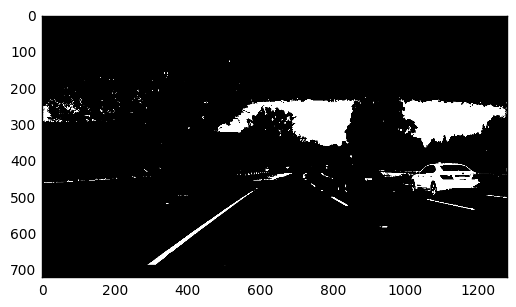

In [93]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('./test_images/test6.jpg')
thresh = (180, 255)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
binary = np.zeros_like(gray)
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1

plt.imshow(binary, cmap='gray')

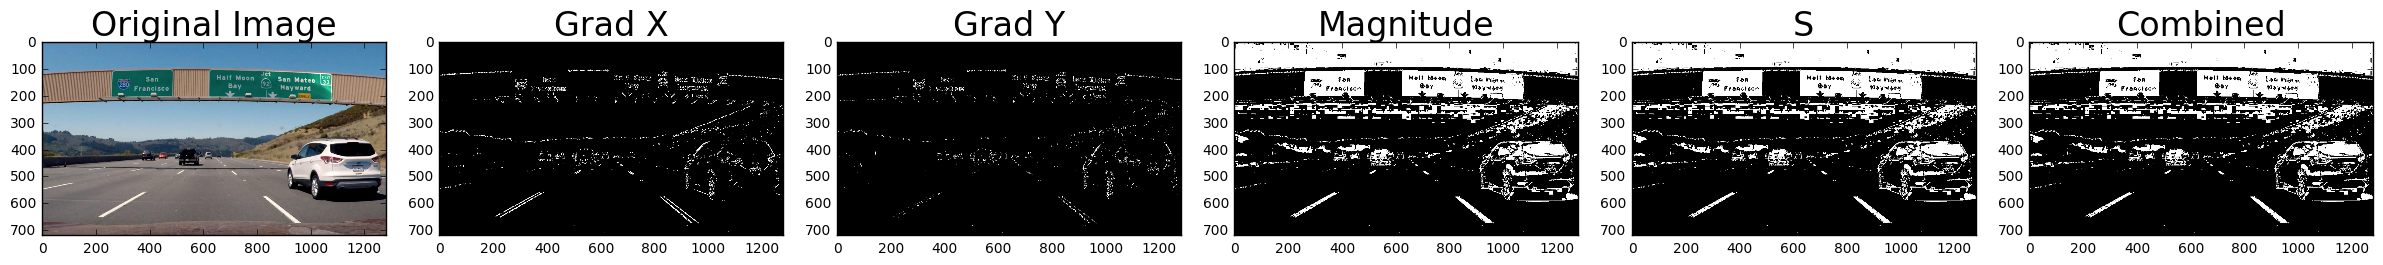

In [119]:
#img = mpimg.imread('./test_images/test6.jpg')
img = mpimg.imread('./signs_vehicles_xygrad.png', np.uint8)


ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))
hls_binary = hls_select(img, thresh=(100, 255))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1)] = 1

combined1 = np.zeros_like(dir_binary)
combined1[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1) & (hls_binary == 1))] = 1

combined2 = np.zeros_like(dir_binary)
combined2[((gradx == 1) & (grady == 1) & (hls_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

combined3 = np.zeros_like(dir_binary)
combined3[((gradx == 1) & (grady == 1)) | (hls_binary == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1

combined4 = np.zeros_like(dir_binary)
combined4[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1)] = 1

f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=24)

ax2.imshow(combined1, cmap='gray')
ax2.set_title('Grad X', fontsize=24)

ax3.imshow(combined2, cmap='gray')
ax3.set_title('Grad Y', fontsize=24)

ax4.imshow(combined3, cmap='gray')
ax4.set_title('Magnitude', fontsize=24)

ax5.imshow(combined4, cmap='gray')
ax5.set_title('S', fontsize=24)

ax6.imshow(combined, cmap='gray')
ax6.set_title('Combined', fontsize=24)

## Perspective Transform

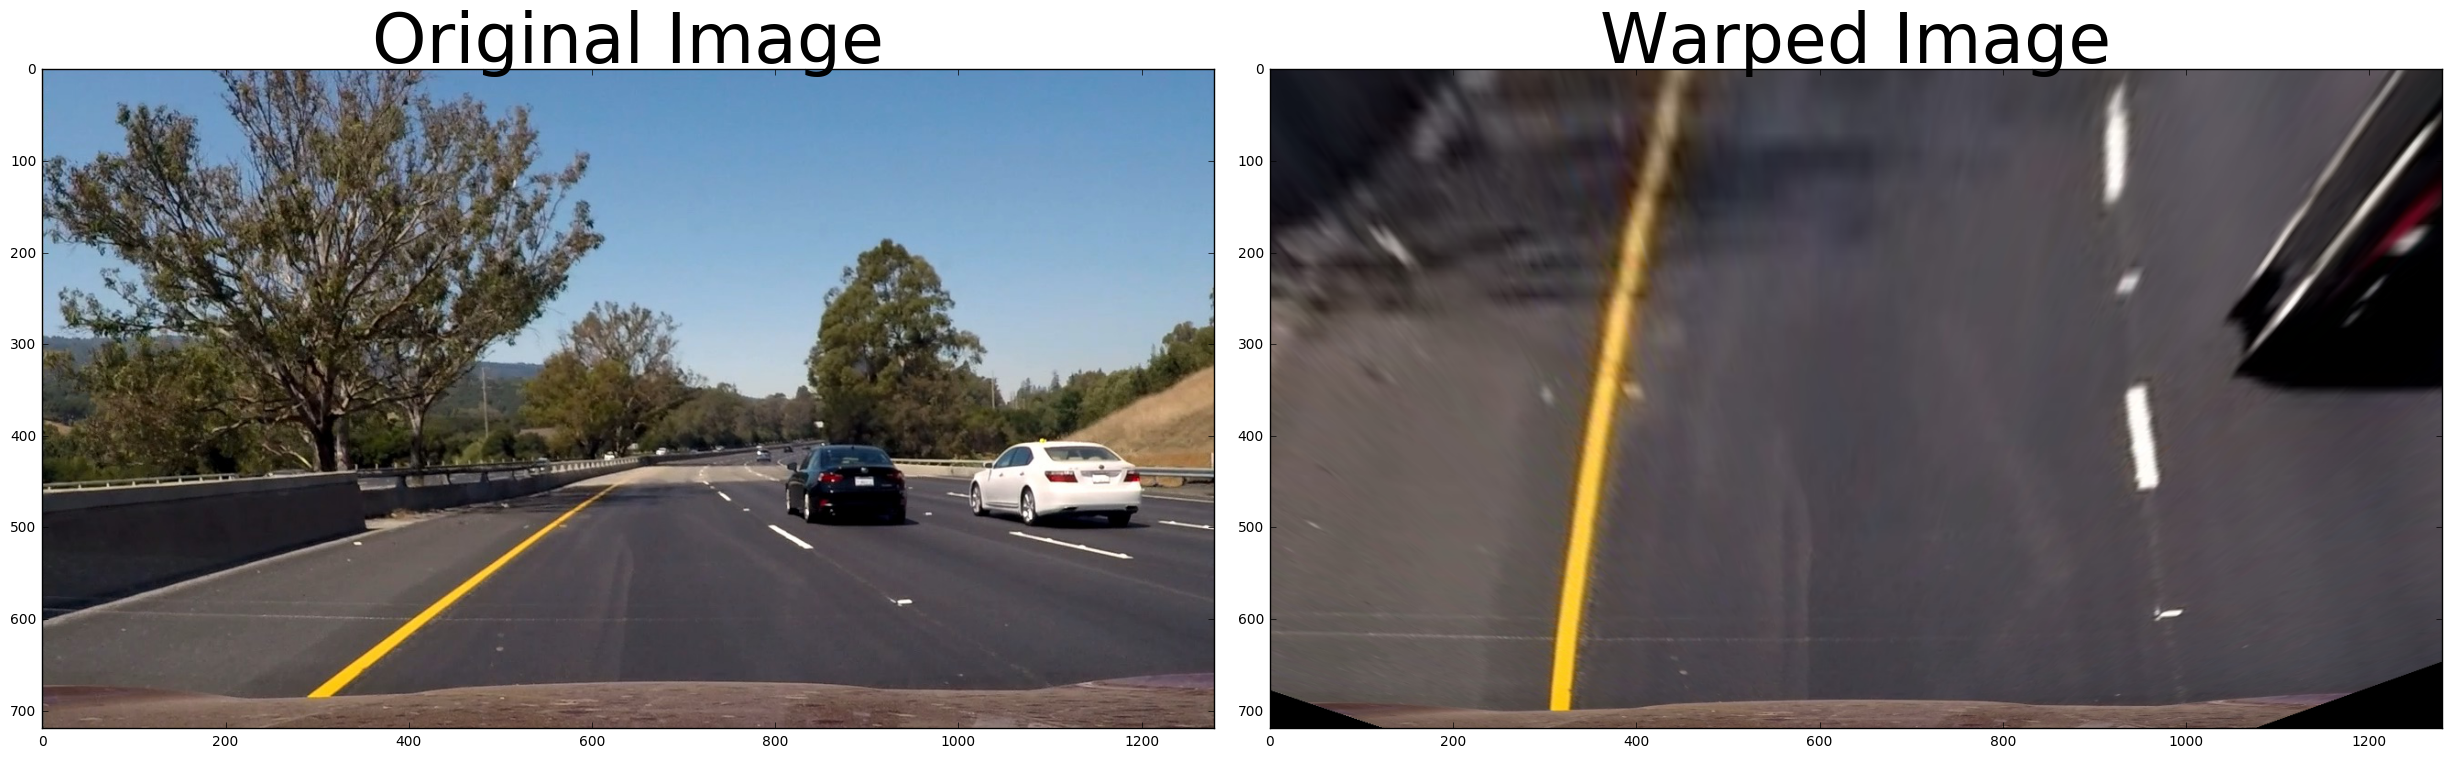

In [267]:
img = mpimg.imread('./test_images/test6.jpg')

img_size = img.shape[1::-1]

src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) + 50), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 105), img_size[1] / 2 + 100]])

dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

M = cv2.getPerspectiveTransform(src, dst)

warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=50)



plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

585.0 460.0
263.333 720.0
1126.67 720.0
745.0 460.0


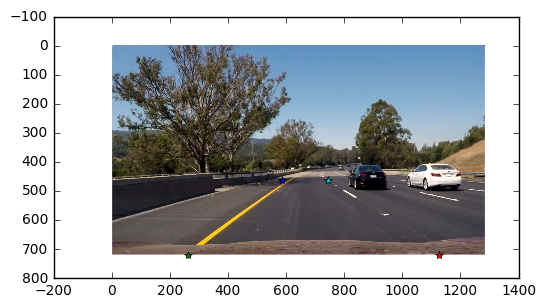

In [268]:
plt.imshow(img)
for x, y in src:
    print(x, y)
    
    plt.plot(x, y, '*')

## Finding Lines

## Fit polynomial

## Draw lines on road